<a href="https://colab.research.google.com/github/TubaSatoglu/PSD-in-Plastic-Scintillator-in-Geant4-using-MLP/blob/main/PSD_in_Plastic_Scintillator_in_Geant4_using_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
DT_NS = 0.1
BASELINE_BINS = 50
BIN_PREFIX = "TimeBin_"
EPS = 1e-12

# Enerji split
TRAIN_ENERGIES = [1.5, 2.0, 2.5, 3.0, 3.5]
VAL_ENERGIES   = [1.0]
TEST_ENERGIES  = [4.0]

# CC window scan
T_SHORT_LIST = np.arange(40, 160, 4)   # ns
T_LONG_LIST  = np.arange(250, 500, 10) # ns
MIN_PER_CLASS = 200

# MLP
EPOCHS = 200
PATIENCE = 10
BATCH_SIZE = 16
LR = 1e-3

def path_gamma(E):
    return f"/content/drive/MyDrive/PSD_data(GAMMA)(E={E}MeV).csv"

def path_neutron(E):
    return f"/content/drive/MyDrive/PSD_data(neutron)(E={E}MeV).csv"


In [ ]:
# Helper functions (preprocess + t0 peak + safe integrate + FoM)

def get_waveforms(df):
    cols = sorted([c for c in df.columns if c.startswith(BIN_PREFIX)],
                  key=lambda x: int(x.split("_")[-1]))
    return df[cols].to_numpy(dtype=np.float64)

def preprocess(w):
    baseline = w[:, :BASELINE_BINS].mean(axis=1, keepdims=True)
    w = w - baseline
    w[w < 0] = 0.0
    return w

# peak alignment
def t0_peak(w):
    return np.argmax(w, axis=1)

def integrate_safe(w, t0, nS, nL):
    """
    Prevent IndexError: only keep events with t0+nL <= T
    """
    N, T = w.shape
    endS = t0 + nS
    endL = t0 + nL
    valid = (t0 >= 0) & (endS <= T) & (endL <= T)

    if valid.sum() == 0:
        return np.array([]), np.array([]), valid

    wv = w[valid]
    t0v = t0[valid]
    endSv = endS[valid]
    endLv = endL[valid]

    cs = np.cumsum(wv, axis=1)
    cs = np.hstack([np.zeros((len(wv), 1)), cs])  # (N, T+1)

    idx = np.arange(len(wv))
    qS = cs[idx, endSv] - cs[idx, t0v]
    qL = cs[idx, endLv] - cs[idx, t0v]
    return qS, qL, valid

def psd_cc(qS, qL):
    return (qL - qS) / (qL + EPS)

def stats_line(name, x):
    return f"{name}: mean={np.mean(x):.6g}, std={np.std(x):.6g}, min={np.min(x):.6g}, max={np.max(x):.6g}"

# FoM: |mu_n - mu_g| / (FWHM_n + FWHM_g)
def fwhm_from_hist(x, bins=200):
    h, e = np.histogram(x, bins=bins)
    c = 0.5*(e[:-1] + e[1:])
    half = h.max()/2.0
    idx = np.where(h >= half)[0]
    if len(idx) < 2:
        return np.nan, np.nan
    mu = c[idx].mean()
    width = c[idx[-1]] - c[idx[0]]
    return mu, width

def fom_hist(psd_gamma, psd_neutron, bins=200):
    mu_g, fwhm_g = fwhm_from_hist(psd_gamma, bins=bins)
    mu_n, fwhm_n = fwhm_from_hist(psd_neutron, bins=bins)
    F = np.abs(mu_n - mu_g) / (fwhm_n + fwhm_g + EPS)
    return F, (mu_g, fwhm_g, mu_n, fwhm_n)


In [ ]:
def load_energy(E):
    dfg = pd.read_csv(path_gamma(E));   dfg["y"] = 1  # gamma positive
    dfn = pd.read_csv(path_neutron(E)); dfn["y"] = 0  # neutron negative
    df = pd.concat([dfg, dfn], ignore_index=True)

    w = preprocess(get_waveforms(df))
    y = df["y"].to_numpy(dtype=np.int64)
    t0 = t0_peak(w)
    return df, w, t0, y

def make_xy(energies):
    Ws, Ys = [], []
    for E in energies:
        _, w, _, y = load_energy(E)
        Ws.append(w); Ys.append(y)
    W = np.vstack(Ws)
    Y = np.concatenate(Ys)
    t0 = t0_peak(W)
    return W, t0, Y

Wtr, t0tr, ytr = make_xy(TRAIN_ENERGIES)
print("TRAIN events:", len(ytr), "| gamma:", (ytr==1).sum(), "| neutron:", (ytr==0).sum())
print("Waveform shape:", Wtr.shape)
print("t0 stats:", t0tr.min(), int(np.median(t0tr)), t0tr.max())


TRAIN events: 65436 | gamma: 15696 | neutron: 49740
Waveform shape: (65436, 5000)
t0 stats: 0 20 4974


CLASSICAL CC PART


===== CC WINDOW OPT (TRAIN energies) =====
TRAIN energies: [1.5, 2.0, 2.5, 3.0, 3.5]
Best windows: {'FoM': -inf, 'Tshort': None, 'Tlong': None}


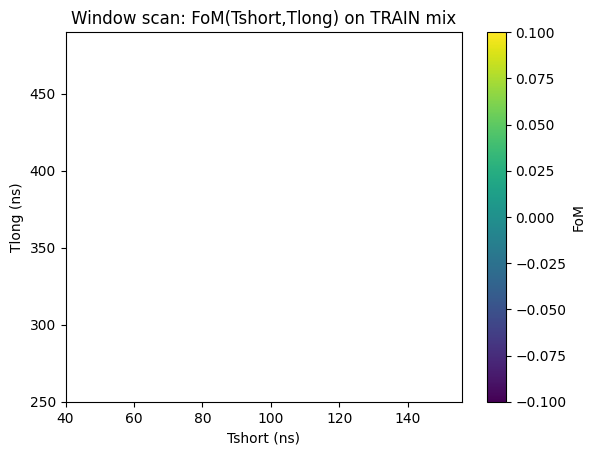

In [ ]:
best = {"FoM": -np.inf, "Tshort": None, "Tlong": None}
FOM_map = np.full((len(T_LONG_LIST), len(T_SHORT_LIST)), np.nan)

for i, Tl in enumerate(T_LONG_LIST):
    nL = int(round(Tl / DT_NS))
    for j, Ts in enumerate(T_SHORT_LIST):
        if Ts >= Tl:
            continue
        nS = int(round(Ts / DT_NS))

        qS, qL, valid = integrate_safe(Wtr, t0tr, nS, nL)
        if len(qL) < 2*MIN_PER_CLASS:
            continue

        psd = psd_cc(qS, qL)
        yy = ytr[valid]

        psd_g = psd[yy == 1]
        psd_n = psd[yy == 0]
        if len(psd_g) < MIN_PER_CLASS or len(psd_n) < MIN_PER_CLASS:
            continue

        F, _ = fom_hist(psd_g, psd_n, bins=200)
        FOM_map[i, j] = F

        if np.isfinite(F) and F > best["FoM"]:
            best = {"FoM": float(F), "Tshort": float(Ts), "Tlong": float(Tl)}

print("\n===== CC WINDOW OPT (TRAIN energies) =====")
print("TRAIN energies:", TRAIN_ENERGIES)
print("Best windows:", best)

plt.figure()
plt.imshow(
    FOM_map, origin="lower", aspect="auto",
    extent=[T_SHORT_LIST[0], T_SHORT_LIST[-1], T_LONG_LIST[0], T_LONG_LIST[-1]]
)
plt.colorbar(label="FoM")
if best["Tshort"] is not None:
    plt.scatter([best["Tshort"]], [best["Tlong"]], marker="x", s=150)
plt.xlabel("Tshort (ns)")
plt.ylabel("Tlong (ns)")
plt.title("Window scan: FoM(Tshort,Tlong) on TRAIN mix")
plt.show()


In [ ]:
def eval_cc_energy(E, Tshort, Tlong):
    _, W, t0, y = load_energy(E)

    nS = int(round(Tshort / DT_NS))
    nL = int(round(Tlong  / DT_NS))

    qS, qL, valid = integrate_safe(W, t0, nS, nL)
    psd = psd_cc(qS, qL)
    yy = y[valid]

    psd_g = psd[yy == 1]
    psd_n = psd[yy == 0]

    F, (mu_g, fwhm_g, mu_n, fwhm_n) = fom_hist(psd_g, psd_n, bins=200)
    fpr, tpr, _ = roc_curve(yy, psd)
    A = auc(fpr, tpr)

    print(f"\n--- CC @ E={E} MeV ---")
    print(f"Tshort={Tshort:.1f} ns, Tlong={Tlong:.1f} ns")
    print(stats_line("Qshort", qS))
    print(stats_line("Qlong ", qL))
    print(stats_line("PSD   ", psd))
    print(f"mu_g={mu_g:.6g}, FWHM_g={fwhm_g:.6g} | mu_n={mu_n:.6g}, FWHM_n={fwhm_n:.6g}")
    print(f"FoM={F:.3f} | AUC={A:.3f} | kept={len(yy)}")

    plt.figure()
    plt.hist(psd_g, bins=200, density=True, alpha=0.6, label="gamma")
    plt.hist(psd_n, bins=200, density=True, alpha=0.6, label="neutron")
    plt.xlabel("PSD = (Qlong-Qshort)/Qlong")
    plt.ylabel("Density")
    plt.title(f"CC PSD histogram @ {E} MeV | FoM={F:.3f} | AUC={A:.3f}")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={A:.3f}")
    plt.plot([0,1],[0,1], "--", label="random")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"ROC (CC) @ {E} MeV")
    plt.grid(True); plt.legend(); plt.show()

    return F, A

if best["Tshort"] is not None:
    for E in TRAIN_ENERGIES + VAL_ENERGIES + TEST_ENERGIES:
        eval_cc_energy(E, best["Tshort"], best["Tlong"])


MLP PART (train/val/test energies split)

In [ ]:
def normalize_peak(W):
    return W / (W.max(axis=1, keepdims=True) + EPS)

W_train, _, y_train = make_xy(TRAIN_ENERGIES)
W_val,   _, y_val   = make_xy(VAL_ENERGIES)
W_test,  _, y_test  = make_xy(TEST_ENERGIES)

W_train = normalize_peak(W_train).astype(np.float32)
W_val   = normalize_peak(W_val).astype(np.float32)
W_test  = normalize_peak(W_test).astype(np.float32)

print("TRAIN:", W_train.shape, "gamma", (y_train==1).sum(), "neutron", (y_train==0).sum())
print("VAL  :", W_val.shape,   "gamma", (y_val==1).sum(),   "neutron", (y_val==0).sum())
print("TEST :", W_test.shape,  "gamma", (y_test==1).sum(),  "neutron", (y_test==0).sum())


TRAIN: (65436, 5000) gamma 15696 neutron 49740
VAL  : (15582, 5000) gamma 4125 neutron 11457
TEST : (10935, 5000) gamma 2286 neutron 8649


In [ ]:
# MLP model (paper-like: 32-32) + pos_weight placement

class WaveDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

class MLP32(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # logits
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

train_loader = DataLoader(WaveDS(W_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(WaveDS(W_val,   y_val),   batch_size=256, shuffle=False)
test_loader  = DataLoader(WaveDS(W_test,  y_test),  batch_size=256, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLP32(W_train.shape[1]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)

# pos_weight: gamma=1 (positive), neutron=0 (negative)
N_pos = (y_train == 1).sum()
N_neg = (y_train == 0).sum()
pos_w = torch.tensor([N_neg / max(N_pos, 1)], dtype=torch.float32).to(device)

lossf = nn.BCEWithLogitsLoss(pos_weight=pos_w)

print("pos_weight used:", float(pos_w))


pos_weight used: 3.1689603328704834


Epoch 001 | train loss=0.2784 | VAL AUC=0.9804
Epoch 002 | train loss=0.1668 | VAL AUC=0.9841
Epoch 003 | train loss=0.1430 | VAL AUC=0.9834
Epoch 004 | train loss=0.1299 | VAL AUC=0.9819
Epoch 005 | train loss=0.1180 | VAL AUC=0.9803
Epoch 006 | train loss=0.1101 | VAL AUC=0.9784
Epoch 007 | train loss=0.1031 | VAL AUC=0.9790
Epoch 008 | train loss=0.0975 | VAL AUC=0.9762
Epoch 009 | train loss=0.0921 | VAL AUC=0.9778
Epoch 010 | train loss=0.0892 | VAL AUC=0.9769
Epoch 011 | train loss=0.0854 | VAL AUC=0.9728
Epoch 012 | train loss=0.0819 | VAL AUC=0.9754
Early stop @ epoch 12 (best VAL AUC=0.9841)


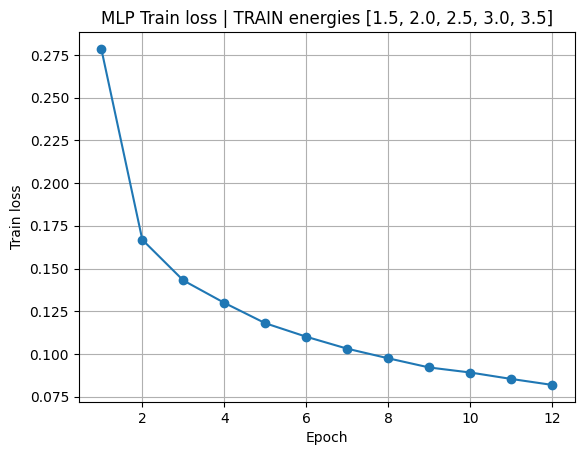

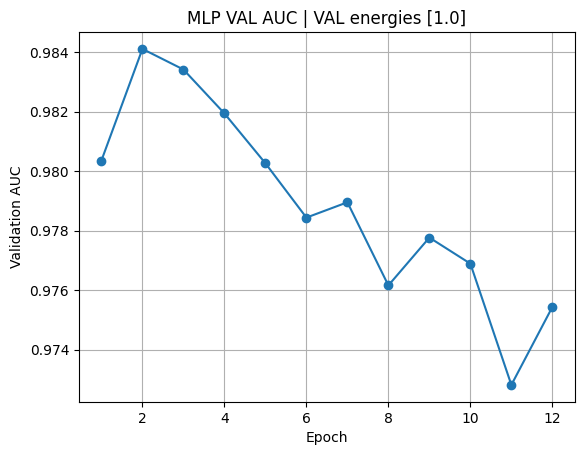

In [ ]:
# Train loop + early stopping (waiting epochs=10)

def eval_probs(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            prob = torch.sigmoid(logits).cpu().numpy()
            ys.append(yb.numpy()); ps.append(prob)
    return np.concatenate(ys), np.concatenate(ps)

best_val_auc = -np.inf
bad_epochs = 0
best_state = None

train_losses = []
val_aucs = []

for ep in range(1, EPOCHS+1):
    model.train()
    running = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        opt.zero_grad()
        logits = model(xb)
        loss = lossf(logits, yb)
        loss.backward()
        opt.step()

        running += loss.item() * len(yb)

    train_loss = running / len(train_loader.dataset)
    train_losses.append(train_loss)

    yv, pv = eval_probs(model, val_loader)
    fpr, tpr, _ = roc_curve(yv, pv)
    val_auc = auc(fpr, tpr)
    val_aucs.append(val_auc)

    print(f"Epoch {ep:03d} | train loss={train_loss:.4f} | VAL AUC={val_auc:.4f}")

    if val_auc > best_val_auc + 1e-4:
        best_val_auc = val_auc
        bad_epochs = 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print(f"Early stop @ epoch {ep} (best VAL AUC={best_val_auc:.4f})")
            break

if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

# learning curves
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, marker="o")
plt.xlabel("Epoch"); plt.ylabel("Train loss")
plt.title(f"MLP Train loss | TRAIN energies {TRAIN_ENERGIES}")
plt.grid(True); plt.show()

plt.figure()
plt.plot(range(1, len(val_aucs)+1), val_aucs, marker="o")
plt.xlabel("Epoch"); plt.ylabel("Validation AUC")
plt.title(f"MLP VAL AUC | VAL energies {VAL_ENERGIES}")
plt.grid(True); plt.show()


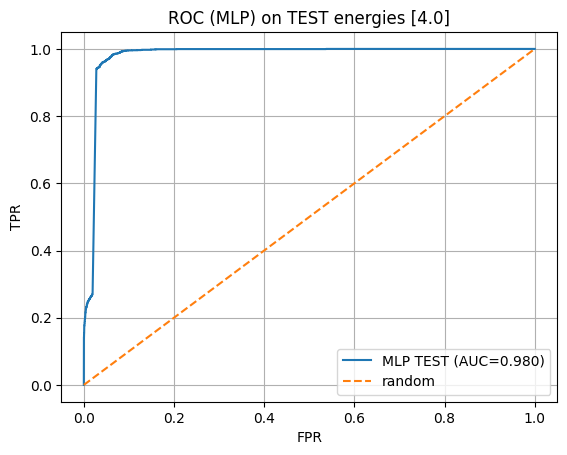


===== MLP TEST METRICS =====
TRAIN energies: [1.5, 2.0, 2.5, 3.0, 3.5]
VAL energies  : [1.0]
TEST energies : [4.0]
AUC=0.980 | thr=0.50
Confusion matrix (rows=true, cols=pred):
 [[7963  686]
 [  27 2259]]

Classification report (gamma=1, neutron=0):
              precision    recall  f1-score   support

  neutron(0)       1.00      0.92      0.96      8649
    gamma(1)       0.77      0.99      0.86      2286

    accuracy                           0.93     10935
   macro avg       0.88      0.95      0.91     10935
weighted avg       0.95      0.93      0.94     10935



In [ ]:
# TEST ROC + Confusion matrix + report
yt, pt = eval_probs(model, test_loader)
fpr, tpr, _ = roc_curve(yt, pt)
A = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"MLP TEST (AUC={A:.3f})")
plt.plot([0,1],[0,1],"--",label="random")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title(f"ROC (MLP) on TEST energies {TEST_ENERGIES}")
plt.grid(True); plt.legend(); plt.show()

# threshold
thr = 0.5
yhat = (pt >= thr).astype(int)

cm = confusion_matrix(yt.astype(int), yhat)
print("\n===== MLP TEST METRICS =====")
print("TRAIN energies:", TRAIN_ENERGIES)
print("VAL energies  :", VAL_ENERGIES)
print("TEST energies :", TEST_ENERGIES)
print(f"AUC={A:.3f} | thr={thr:.2f}")
print("Confusion matrix (rows=true, cols=pred):\n", cm)

print("\nClassification report (gamma=1, neutron=0):")
print(classification_report(yt.astype(int), yhat, target_names=["neutron(0)", "gamma(1)"]))


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset, DataLoader

DT_NS = 0.1
BASELINE_BINS = 50
BIN_PREFIX = "TimeBin_"
EPS = 1e-12

TRAIN_ENERGIES = [1.5, 2.0, 2.5, 3.0, 3.5]
VAL_ENERGIES   = [1.0]
TEST_ENERGIES  = [4.0]

T_SHORT_LIST = np.arange(40, 160, 4)   # ns
T_LONG_LIST  = np.arange(250, 500, 10) # ns
MIN_PER_CLASS = 200

EPOCHS = 200
PATIENCE = 10
BATCH_SIZE = 16
LR = 1e-3

DATA_ROOT = "/content/drive/MyDrive"

def path_gamma(E):
    return os.path.join(DATA_ROOT, f"PSD_data(GAMMA)(E={E}MeV).csv")

def path_neutron(E):
    return os.path.join(DATA_ROOT, f"PSD_data(neutron)(E={E}MeV).csv")

OUTDIR = "outputs_psd"
os.makedirs(OUTDIR, exist_ok=True)

POS_LABEL_NAME = "gamma(1)"
NEG_LABEL_NAME = "neutron(0)"

def _read_wave_csv(filepath: str) -> np.ndarray:
    """
    CSV -> (N, 5000) numpy array
    Kolonlar TimeBin_0 ... TimeBin_4999 şeklinde varsayılır.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Missing file: {filepath}")

    df = pd.read_csv(filepath)
    cols = [c for c in df.columns if c.startswith(BIN_PREFIX)]
    if len(cols) == 0:
        raise ValueError(f"No columns starting with '{BIN_PREFIX}' in: {filepath}")

    def _k(c):
        # "TimeBin_123" -> 123
        return int(c.split("_")[-1])
    cols = sorted(cols, key=_k)

    W = df[cols].to_numpy(dtype=np.float32)
    return W

def make_xy(energies):
    """
    energies: list[float]
    returns:
      W: (N, 5000)
      t0_dummy: None (senin eski signature'ına uyum için)
      y: (N,) gamma=1, neutron=0
    """
    Ws = []
    ys = []

    for E in energies:
        Wg = _read_wave_csv(path_gamma(E))
        Wn = _read_wave_csv(path_neutron(E))

        yg = np.ones(len(Wg), dtype=np.int64)   # gamma=1
        yn = np.zeros(len(Wn), dtype=np.int64)  # neutron=0

        Ws.append(Wg); ys.append(yg)
        Ws.append(Wn); ys.append(yn)

    W = np.concatenate(Ws, axis=0)
    y = np.concatenate(ys, axis=0)
    return W, None, y

def normalize_peak(W):
    return W / (W.max(axis=1, keepdims=True) + EPS)

class WaveDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

@torch.no_grad()
def eval_probs_from_arrays(model, X, y, device, batch_size=256):
    """
    X,y numpy -> probability (sigmoid(logit))
    """
    loader = DataLoader(WaveDS(X, y), batch_size=batch_size, shuffle=False)
    model.eval()

    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)             # logits
        prob = torch.sigmoid(logits)   # prob
        ys.append(yb.numpy())
        ps.append(prob.detach().cpu().numpy())

    return np.concatenate(ys), np.concatenate(ps)

def roc_auc_from_arrays(model, X, y, device):
    yt, pt = eval_probs_from_arrays(model, X, y, device)
    fpr, tpr, thr = roc_curve(yt, pt)
    A = auc(fpr, tpr)
    return fpr, tpr, thr, A, yt, pt


def plot_single_test_roc(model, device, test_energies=TEST_ENERGIES, thr0=0.5):
    W_test, _, y_test = make_xy(test_energies)
    W_test = normalize_peak(W_test).astype(np.float32)

    fpr, tpr, thr, A, yt, pt = roc_auc_from_arrays(model, W_test, y_test, device)

    plt.figure()
    plt.plot(fpr, tpr, label=f"MLP TEST (AUC={A:.3f})")
    plt.plot([0, 1], [0, 1], "--", label="random")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC (MLP) on TEST energies {test_energies}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    outpath = os.path.join(OUTDIR, "roc_curve_single_energy.png")
    plt.savefig(outpath, dpi=300)
    plt.close()
    print("[saved]", outpath)

    # threshold=0.5 raporu
    yhat = (pt >= thr0).astype(int)
    cm = confusion_matrix(yt.astype(int), yhat)
    print("\nConfusion matrix (rows=true, cols=pred):\n", cm)
    print("\nClassification report (gamma=1, neutron=0):")
    print(classification_report(
        yt.astype(int), yhat,
        target_names=[NEG_LABEL_NAME, POS_LABEL_NAME]
    ))

    return A

# =========================================================
# ROC by energy overlay (+ zoom) + AUC vs energy
# =========================================================

def plot_roc_by_energy(model, device, energies_for_roc):
    roc_by_E = {}  # E -> (fpr,tpr,A)

    for E in energies_for_roc:
        W_E, _, y_E = make_xy([E])
        W_E = normalize_peak(W_E).astype(np.float32)
        fprE, tprE, _, AE, _, _ = roc_auc_from_arrays(model, W_E, y_E, device)
        roc_by_E[E] = (fprE, tprE, AE)

    # overlay ROC
    plt.figure()
    for E in energies_for_roc:
        fprE, tprE, AE = roc_by_E[E]
        plt.plot(fprE, tprE, label=f"{E:.1f} MeV (AUC={AE:.3f})")
    plt.plot([0, 1], [0, 1], "--", label="random")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC curves by energy (MLP)")
    plt.grid(True)
    plt.legend(fontsize=8)
    plt.tight_layout()
    outpath = os.path.join(OUTDIR, "roc_by_energy.png")
    plt.savefig(outpath, dpi=300)
    plt.close()
    print("[saved]", outpath)

    # zoom
    plt.figure()
    for E in energies_for_roc:
        fprE, tprE, AE = roc_by_E[E]
        plt.plot(fprE, tprE, label=f"{E:.1f} MeV (AUC={AE:.3f})")
    plt.xlim(0.0, 0.10)
    plt.ylim(0.0, 1.00)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC curves by energy (MLP) — zoomed FPR")
    plt.grid(True)
    plt.legend(fontsize=8)
    plt.tight_layout()
    outpath = os.path.join(OUTDIR, "roc_by_energy_zoom.png")
    plt.savefig(outpath, dpi=300)
    plt.close()
    print("[saved]", outpath)

    # AUC vs energy
    Es = np.array(sorted(roc_by_E.keys()), dtype=float)
    AUCs = np.array([roc_by_E[e][2] for e in Es], dtype=float)

    plt.figure()
    plt.plot(Es, AUCs, marker="o")
    plt.xlabel("Energy (MeV)")
    plt.ylabel("ROC-AUC")
    plt.title("MLP performance vs energy (ROC-AUC)")
    plt.grid(True)
    plt.tight_layout()
    outpath = os.path.join(OUTDIR, "auc_vs_energy.png")
    plt.savefig(outpath, dpi=300)
    plt.close()
    print("[saved]", outpath)

    return roc_by_E


def plot_fom_vs_auc_energy(roc_by_E, cc_fom_by_E):
    """
    roc_by_E: dict E -> (fpr,tpr,AUC_mlp)
    cc_fom_by_E: dict E -> FoM_cc
    """
    Es = np.array(sorted(roc_by_E.keys()), dtype=float)
    AUCs = np.array([roc_by_E[e][2] for e in Es], dtype=float)

    # CC FoM olan enerjileri kesişimden al
    Es_fom = np.array(sorted(set(cc_fom_by_E.keys()).intersection(set(roc_by_E.keys()))), dtype=float)
    FOMs = np.array([cc_fom_by_E[e] for e in Es_fom], dtype=float)

    plt.figure()
    plt.plot(Es, AUCs, marker="o", label="MLP ROC-AUC")
    plt.plot(Es_fom, FOMs, marker="s", label="CC FoM")
    plt.xlabel("Energy (MeV)")
    plt.title("Comparison of CC FoM and MLP ROC-AUC as a function of energy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    outpath = os.path.join(OUTDIR, "fom_vs_auc_energy.png")
    plt.savefig(outpath, dpi=300)
    plt.close()
    print("[saved]", outpath)


if __name__ == "__main__":
    try:
        device
        model
    except NameError:
        raise RuntimeError(
            "You must define 'device' and an already-trained 'model' before running plots.\n"
            "Example:\n"
            "  device = 'cuda' if torch.cuda.is_available() else 'cpu'\n"
            "  model = MLP32(n_in=5000).to(device)\n"
            "  model.load_state_dict(torch.load('best_model.pt', map_location=device))\n"
        )

    plot_single_test_roc(model, device, TEST_ENERGIES, thr0=0.5)

    ENERGIES_FOR_ROC = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
    roc_by_E = plot_roc_by_energy(model, device, ENERGIES_FOR_ROC)


[saved] outputs_psd/roc_curve_single_energy.png

Confusion matrix (rows=true, cols=pred):
 [[8299  350]
 [ 378 1908]]

Classification report (gamma=1, neutron=0):
              precision    recall  f1-score   support

  neutron(0)       0.96      0.96      0.96      8649
    gamma(1)       0.84      0.83      0.84      2286

    accuracy                           0.93     10935
   macro avg       0.90      0.90      0.90     10935
weighted avg       0.93      0.93      0.93     10935

[saved] outputs_psd/roc_by_energy.png
[saved] outputs_psd/roc_by_energy_zoom.png
[saved] outputs_psd/auc_vs_energy.png


In [ ]:
def load_energy_safe(E):

    out = load_energy(E)

    if not isinstance(out, (tuple, list)):
        raise ValueError(f"load_energy({E}) tuple/list dönmeli, ama {type(out)} döndü.")

    if len(out) == 3:
        W, t0, y = out
        return W, t0, y

    if len(out) == 4:
        _, W, t0, y = out
        return W, t0, y


def eval_cc_energy_savefig(E, Tshort, Tlong):
    W, t0, y = load_energy_safe(E)

    nS = int(round(Tshort / DT_NS))
    nL = int(round(Tlong  / DT_NS))

    qS, qL, valid = integrate_safe(W, t0, nS, nL)
    psd = psd_cc(qS, qL)
    yy = y[valid]

    psd_g = psd[yy == 1]
    psd_n = psd[yy == 0]

    F, (mu_g, fwhm_g, mu_n, fwhm_n) = fom_hist(psd_g, psd_n, bins=200)
    fpr, tpr, _ = roc_curve(yy, psd)
    A = auc(fpr, tpr)

    print(f"\n--- CC @ E={E} MeV ---")
    print(f"Tshort={Tshort:.1f} ns, Tlong={Tlong:.1f} ns")
    print(f"mu_g={mu_g:.6g}, FWHM_g={fwhm_g:.6g} | mu_n={mu_n:.6g}, FWHM_n={fwhm_n:.6g}")
    print(f"FoM={F:.3f} | AUC={A:.3f} | kept={len(yy)}")

    hpath = os.path.join(OUTDIR, f"cc_hist_E{E:.1f}.png")
    plt.figure()
    plt.hist(psd_g, bins=200, density=True, alpha=0.6, label="gamma")
    plt.hist(psd_n, bins=200, density=True, alpha=0.6, label="neutron")
    plt.xlabel("PSD = (Qlong-Qshort)/Qlong")
    plt.ylabel("Density")
    plt.title(f"CC PSD histogram @ {E:.1f} MeV | FoM={F:.3f} | AUC={A:.3f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(hpath, dpi=300)
    plt.close()
    print("[saved]", hpath)

    # ROC
    rpath = os.path.join(OUTDIR, f"cc_roc_E{E:.1f}.png")
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={A:.3f}")
    plt.plot([0, 1], [0, 1], "--", label="random")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC (CC) @ {E:.1f} MeV")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(rpath, dpi=300)
    plt.close()
    print("[saved]", rpath)

    return F, A


In [ ]:
Es_cc, FOM_cc, AUC_cc = build_fom_auc_vs_energy_cc(ENERGIES_FOR_ROC, Tshort_best, Tlong_best)
plot_fom_vs_auc_energy(Es, FOM_cc, AUCs_mlp,
                       outpath=os.path.join(OUTDIR, "fom_vs_auc_energy.png"))



--- CC @ E=1.0 MeV ---
Tshort=80.0 ns, Tlong=350.0 ns
mu_g=nan, FWHM_g=nan | mu_n=nan, FWHM_n=nan
FoM=nan | AUC=0.424 | kept=15398
[saved] outputs_psd/cc_hist_E1.0.png
[saved] outputs_psd/cc_roc_E1.0.png

--- CC @ E=1.5 MeV ---
Tshort=80.0 ns, Tlong=350.0 ns
mu_g=nan, FWHM_g=nan | mu_n=nan, FWHM_n=nan
FoM=nan | AUC=0.427 | kept=15559
[saved] outputs_psd/cc_hist_E1.5.png
[saved] outputs_psd/cc_roc_E1.5.png

--- CC @ E=2.0 MeV ---
Tshort=80.0 ns, Tlong=350.0 ns
mu_g=nan, FWHM_g=nan | mu_n=nan, FWHM_n=nan
FoM=nan | AUC=0.432 | kept=13038
[saved] outputs_psd/cc_hist_E2.0.png
[saved] outputs_psd/cc_roc_E2.0.png

--- CC @ E=2.5 MeV ---
Tshort=80.0 ns, Tlong=350.0 ns
mu_g=nan, FWHM_g=nan | mu_n=nan, FWHM_n=nan
FoM=nan | AUC=0.437 | kept=12945
[saved] outputs_psd/cc_hist_E2.5.png
[saved] outputs_psd/cc_roc_E2.5.png

--- CC @ E=3.0 MeV ---
Tshort=80.0 ns, Tlong=350.0 ns
mu_g=nan, FWHM_g=nan | mu_n=nan, FWHM_n=nan
FoM=nan | AUC=0.441 | kept=11788
[saved] outputs_psd/cc_hist_E3.0.png
[saved] out